# URL Phishing Detection: Model Training and Analysis

This notebook loads processed URL features, trains multiple models, and provides a full analysis pipeline for phishing detection.

In [1]:
# --- Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from xgboost import XGBClassifier, plot_importance
import warnings

# import all of the models
from models.url import config as url_config
from models.content import config as content_config
from models.meta import config as meta_config

from jupyter_helper import plot_class_balance , split_data, train_and_evaluate_models, cross_validate_models

warnings.filterwarnings('ignore')


## 1. Load Data
We use the processed URL features CSV and the processed Content features CSV.

URL

In [2]:
# Load url data
url_df = pd.read_csv(url_config.PROCESSED_PATH)
print(f'Data shape: {url_df.shape}')
url_df.head()

Data shape: (1141207, 15)


,url_length,path_depth,num_subdomains,num_special_chars,num_digits,num_hyphens,has_at_symbol,num_query_params,digit_ratio,url_entropy,has_https,levenshtein_to_brand,uncommon_tld,url_token_count,label
0,87,9,0,15,0,1,0,0,0.0,4.193923,1,7,0,12,0
1,38,0,0,7,0,0,0,1,0.0,3.988077,1,5,0,5,0
2,58,3,0,9,0,1,0,0,0.0,4.070934,1,10,1,6,0
3,39,0,1,10,0,4,0,0,0.0,3.967862,1,4,0,2,1
4,40,0,0,9,4,0,0,2,0.1,4.415312,1,5,0,7,0


Content

In [3]:
# Load content data
content_df = pd.read_csv(content_config.PROCESSED_PATH)
content_df.head()

,html_tag_count,form_count,input_count,anchor_count,script_count,iframe_count,img_count,meta_refresh_count,title_length,text_to_html_ratio,...,external_stylesheet_ratio,non_https_resource_ratio,domain_mismatch_link_ratio,password_reset_link_count,external_resource_count,favicon_domain_mismatch,redirect_pattern_count,external_domain_count,ad_network_asset_count,label
0,545,2,13,22,0,0,1,0,35,0.034563,...,1.0,1.000000,1.000000,0,1,1,0,2,0,1
1,12,0,0,0,3,0,0,0,0,0.000000,...,1.0,1.000000,0.000000,0,3,0,0,0,0,1
2,282,1,2,77,8,0,4,0,61,0.082859,...,1.0,0.000000,0.896104,0,6,1,2,8,0,0
3,863,3,2,179,48,1,0,0,30,0.051616,...,0.5,0.419355,0.122905,0,31,0,0,18,1,0
4,268,0,0,34,12,0,23,0,51,0.128032,...,1.0,0.969697,0.823529,0,33,0,0,3,0,0


## 2. Exploratory Data Analysis (EDA)
Check class balance and feature distributions.

URL

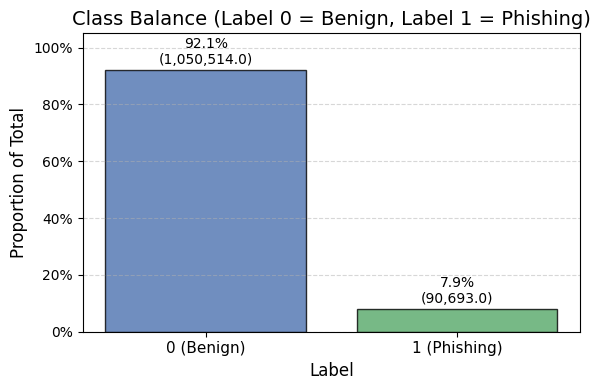

In [4]:
plot_class_balance(df=url_df)

Content

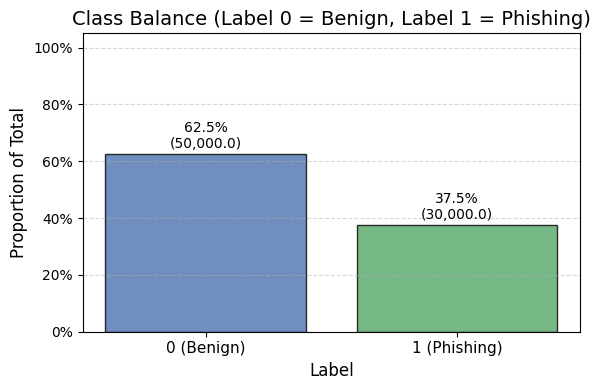

In [5]:
plot_class_balance(df=content_df)

## 3. Train/Test Split
We use a stratified split to preserve class balance.

URL


In [6]:
url_X_train, url_X_test, url_y_train, url_y_test = split_data(df=url_df, feature_cols=url_config.FEATURES)

Train shape: (912965, 14), Test shape: (228242, 14)


Content

In [7]:
content_X_train, content_X_test, content_y_train, content_y_test = split_data(df=content_df, feature_cols=content_config.FEATURES)


Train shape: (64000, 26), Test shape: (16000, 26)


## 4. Model Training with Cross-Validation
We train Logistic Regression, Random Forest, and XGBoost.

URL

In [8]:
url_model = XGBClassifier(**url_config.XGB_PARAMS)
url_model_name = "url_XGBoost"

url_results = cross_validate_models(url_model_name, url_model, url_X_train, url_y_train)


Cross‐Validation Results:

            F1 Mean  F1 Std Elapsed (s)
Model                                  
url_XGBoost  0.9122  0.0011       27.52


Content

In [9]:
content_model = XGBClassifier(**content_config.XGB_PARAMS)
content_model_name = "content_XGBoost"

content_results = cross_validate_models(content_model_name, content_model, content_X_train, content_y_train)



Cross‐Validation Results:

                F1 Mean  F1 Std Elapsed (s)
Model                                      
content_XGBoost  0.9565  0.0030        8.71


## 5. Fit Models and Evaluate on Test Set
We fit each model and evaluate using ROC, confusion matrix, and classification report.

URL


=== url_XGBoost ===
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    210103
           1       0.93      0.89      0.91     18139

    accuracy                           0.99    228242
   macro avg       0.96      0.94      0.95    228242
weighted avg       0.99      0.99      0.99    228242



<Figure size 600x400 with 0 Axes>

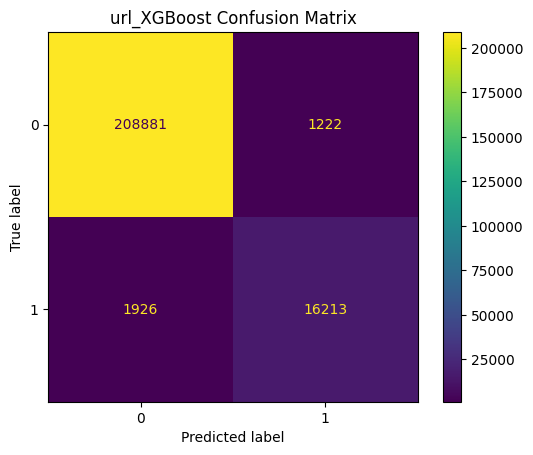

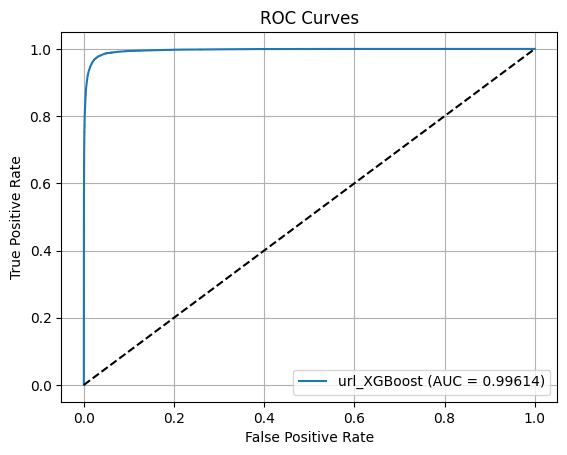

In [10]:
url_train_and_evaluate_models = train_and_evaluate_models(url_model_name, url_model, url_X_train, url_y_train, url_X_test, url_y_test)

Content



=== content_XGBoost ===
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     10000
           1       0.96      0.97      0.96      6000

    accuracy                           0.97     16000
   macro avg       0.97      0.97      0.97     16000
weighted avg       0.97      0.97      0.97     16000



<Figure size 600x400 with 0 Axes>

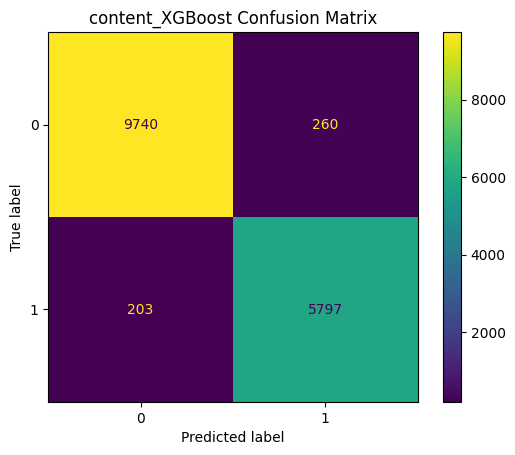

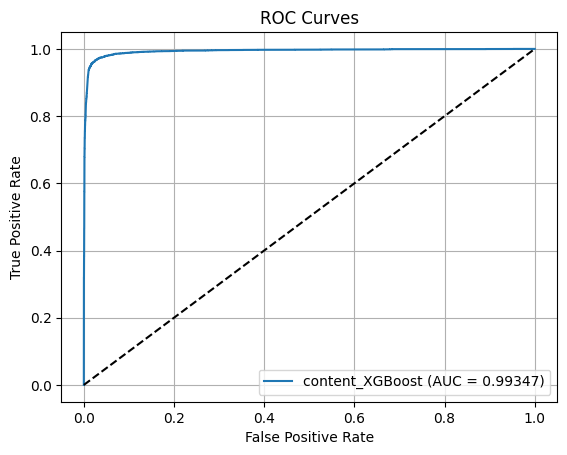

In [11]:
content_train_and_evaluate_models = train_and_evaluate_models(content_model_name, content_model, content_X_train, content_y_train, content_X_test, content_y_test)

## 6. Feature Importance (Tree Models)
We plot feature importances for Random Forest and XGBoost.

URL

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

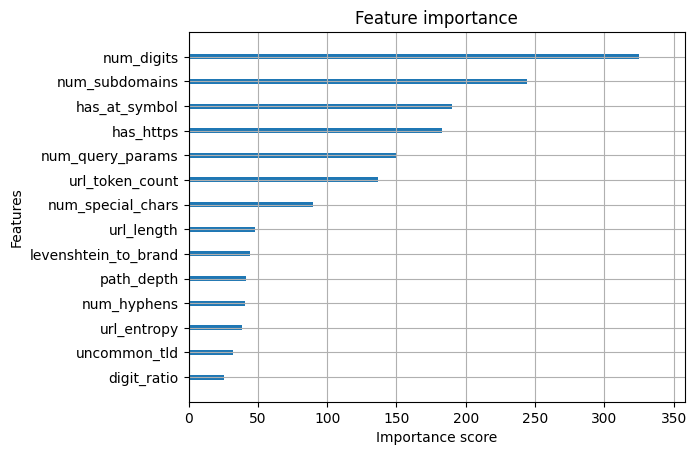

In [12]:

plot_importance(url_model, importance_type='gain', show_values=False)

Content

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

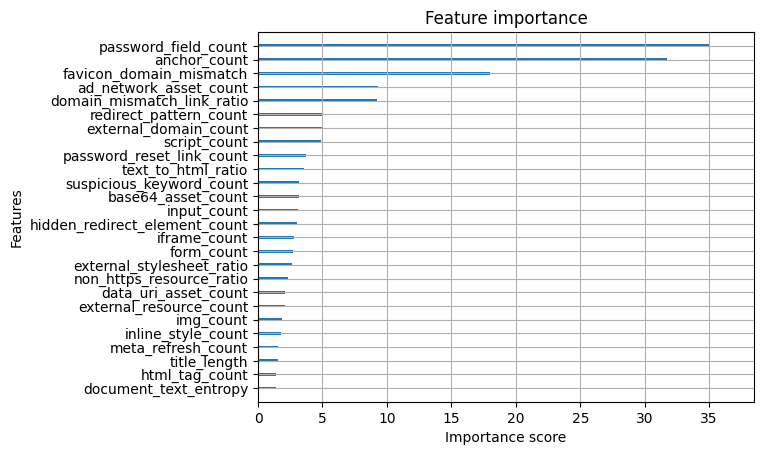

In [13]:
plot_importance(content_model, importance_type='gain', show_values=False)

## Running the Meta model

In [14]:
meta_url_df = pd.read_csv(meta_config.URL_PROCESSED_PATH)
meta_content_df = pd.read_csv(meta_config.CONTENT_PROCESSED_PATH)

meta_model = XGBClassifier(**meta_config.META_XGB_PARAMS)
meta_model_name = "meta_XGBoost"


In [15]:
# 1. Grab the index (or any unique key) from one of the dataframes.
all_indices = meta_url_df.index

# 2. Do a single train/test split on those indices:
train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.2,
    stratify=meta_url_df['label'],  # use one set of labels for stratification
    random_state=42
)

# 3. Use those same train/test indices for both URL and content:
meta_url_X_train = meta_url_df.loc[train_idx, url_config.FEATURES]
meta_url_X_test  = meta_url_df.loc[test_idx,  url_config.FEATURES]
meta_url_y_train = meta_url_df.loc[train_idx, 'label']
meta_url_y_test  = meta_url_df.loc[test_idx,  'label']

meta_content_X_train = meta_content_df.loc[train_idx, content_config.FEATURES]
meta_content_X_test  = meta_content_df.loc[test_idx,  content_config.FEATURES]
# (Assuming meta_content_df has the exact same row order and labels aligned to meta_url_df)
meta_content_y_train = meta_content_df.loc[train_idx, 'label']
meta_content_y_test  = meta_content_df.loc[test_idx,  'label']


In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
N_train = len(meta_url_X_train)

# Prepare empty arrays to hold OOF probabilities
url_oof_proba     = np.zeros(N_train)
content_oof_proba = np.zeros(N_train)

# 5‐fold OOF for URL model
url_oof_proba = cross_val_predict(
    url_model,                    # an *untrained* instance
    meta_url_X_train,
    meta_url_y_train,
    cv=skf,
    method="predict_proba"
)[:, 1]

# 5‐fold OOF for Content model
content_oof_proba = cross_val_predict(
    content_model,
    meta_content_X_train,
    meta_content_y_train,
    cv=skf,
    method="predict_proba"
)[:, 1]


# Now build the *true* meta‐training DataFrame:
meta_train_df = pd.DataFrame({
    'url_pred_proba':     url_oof_proba,
    'content_pred_proba': content_oof_proba
})
meta_y_train = meta_url_y_train.reset_index(drop=True)  # must align length N_train

In [17]:
# A) OOF stage above produces meta_train_df / meta_y_train

# B) Now fit base models on entire training set:
url_model.fit(meta_url_X_train, meta_url_y_train)
content_model.fit(meta_content_X_train, meta_content_y_train)

# C) Compute true “test” meta-features (no data leakage here, because test rows were never used above):
url_pred_proba_test     = url_model.predict_proba(meta_url_X_test)[:, 1]
content_pred_proba_test = content_model.predict_proba(meta_content_X_test)[:, 1]

meta_test_df  = pd.DataFrame({
    'url_pred_proba':     url_pred_proba_test,
    'content_pred_proba': content_pred_proba_test
})
meta_y_test = meta_url_y_test.reset_index(drop=True)  # length = N_test

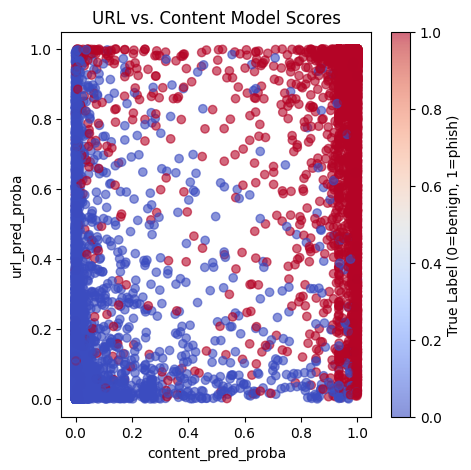

In [18]:
plt.figure(figsize=(5,5))
plt.scatter(
    content_pred_proba_test,
    url_pred_proba_test,
    c=meta_y_test,  # color by true label (0 vs. 1)
    cmap='coolwarm',
    alpha=0.6
)
plt.xlabel("content_pred_proba")
plt.ylabel("url_pred_proba")
plt.title("URL vs. Content Model Scores")
plt.colorbar(label="True Label (0=benign, 1=phish)")
plt.show()


=== meta_XGBoost ===
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10000
           1       0.98      0.97      0.97      6000

    accuracy                           0.98     16000
   macro avg       0.98      0.98      0.98     16000
weighted avg       0.98      0.98      0.98     16000



<Figure size 600x400 with 0 Axes>

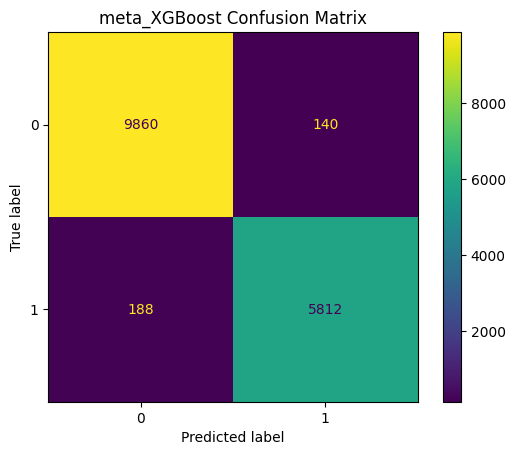

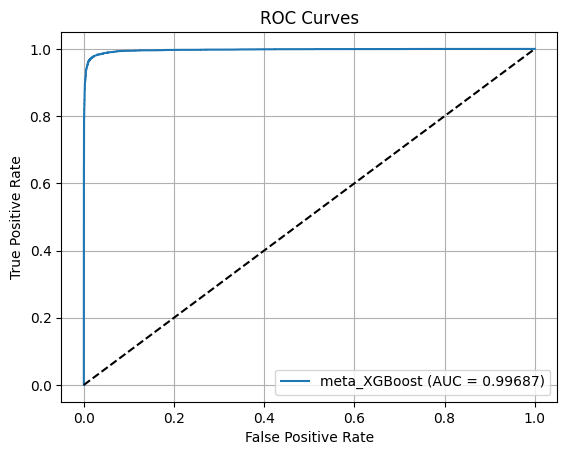

In [19]:
results = train_and_evaluate_models(
    meta_model_name,
    meta_model,
    meta_train_df,            # features the meta model trains on
    meta_y_train,             # labels for those
    meta_test_df,             # features for final evaluation
    meta_y_test               # their labels
)